In [1]:
import sys
import os
import torch
import transformers
from dataset.imdb import load_documents, load_datasets, annotations_from_jsonl
from visualization.utils import create_text_heat_map
import numpy as np
from IPython.display import display, HTML
from tqdm import tqdm
sys.path.insert(0, "/home/farnoush/symbolicXAI")
from model.transformer import tiny_transformer_with_3_layers, bert_base_uncased_model
from model.utils import load_pretrained_weights
from lrp.symbolic_xai import TransformerSymbXAI, BERTSymbXAI
from datasets import load_dataset
from visualization.utils import rescale_score_by_abs, getRGB, span_word, html_heatmap, \
make_text_string, make_color, vis_tree_heat

/home/farnoush/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/farnoush/venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/farnoush/venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Prepare Movie Reviews dataset

In [ ]:
# Load Movie Reviews dataset
data_root = '/home/farnoush/fairness/movies'
documents = load_documents(data_root)
val = annotations_from_jsonl(os.path.join(data_root, 'val.jsonl'))
_, val, _ = load_datasets(data_root)

# Prepare the text.
ann = val[186]
evidences = ann.all_evidences()
(doc_id,) = set(ev.docid for ev in evidences)
doc = documents[doc_id]

text = None
for i, sent in enumerate(doc):
    sentence = ' '.join(sent)
    if i == 0:
        text = sentence
    else:
        text += (' ' + sentence)
        
    print(sentence)

In [ ]:
words = []
for sent in doc:
    for word in sent:
        
        words.append(word)

In [ ]:
for ev in evidences:
    print(ev.text)

## Preprocess the data

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
label = 0 if ann.classification == 'POS'else 1
print(label)
target = torch.nn.functional.one_hot(
    torch.tensor(label), num_classes=2)
target = torch.tensor([1, -1])

sample = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    truncation = True
)
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())

## Create the model

In [ ]:
# Create model.
tiny_transformer = tiny_transformer_with_3_layers(
    pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2"
)
pretrained_embeddings = tiny_transformer.bert.embeddings

# Load pre-trained weights.
load_pretrained_weights(
    tiny_transformer,
    '/home/farnoush/fairness/best_model_state_dropout_0.881.bin'
)

symb_xai_transformer = TransformerSymbXAI(
    model=tiny_transformer,
    embeddings=pretrained_embeddings,
    sample=sample,
    target=target
)

In [ ]:
R1 = symb_xai_transformer.subgraph_relevance(subgraph=range(77, 82), from_walks=False)
print("['this', 'film', 'features', 'good', 'performances']: {}".format(R1))
R = np.zeros(len(words))
R[77: 82] = R1 * 10

R2 = symb_xai_transformer.subgraph_relevance(subgraph=range(100, 103), from_walks=False)
print("['knows', 'her', 'stuff']: {}".format(R2))
R[100: 103] = R2 * 10

R3 = symb_xai_transformer.subgraph_relevance(subgraph=range(83, 88), from_walks=False)
print("['impressive', 'film', '-', 'making', 'technique']: {}".format(R3))
R[83: 88] = R3 * 10

R4 = symb_xai_transformer.subgraph_relevance(subgraph=range(171, 176), from_walks=False)
print("['fails', 'to', 'achieve', 'its', 'goals']: {}".format(R4))
R[171: 176] = R4 * 10

R5 = symb_xai_transformer.subgraph_relevance(subgraph=range(177, 182), from_walks=False)
print("['it', 'fails', 'badly', 'and', 'obviously']: {}".format(R5))
R[177: 182] = R5 * 10

R6 = symb_xai_transformer.subgraph_relevance(subgraph=range(119, 124), from_walks=False)
print("['un', '##sat', '##is', '##fying', 'movie']: {}".format(R6))
R[119: 124] = R6 * 10

R7 = symb_xai_transformer.subgraph_relevance(subgraph=range(89, 94), from_walks=False)
print("['breath', '-', 'taking', 'crowd', 'scenes']: {}".format(R6))
R[89: 94] = R7 * 10

print('________________________________________________________________________________ \n')
display(HTML(create_text_heat_map(words, R.squeeze(), break_at=21, font_size=15)))

In [2]:
from datasets import load_dataset

dataset = load_dataset("movie_rationales")

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")

# Create model.
tiny_transformer = tiny_transformer_with_3_layers(
    pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2"
)

tiny_transformer.bert.embeddings.requires_grad = False
for name, param in tiny_transformer.named_parameters():                
    if name.startswith('embeddings'):
        param.requires_grad = False
pretrained_embeddings = tiny_transformer.bert.embeddings

# Load pre-trained weights.
load_pretrained_weights(
    tiny_transformer,
        '/home/farnoush/fairness/best_model_state_dropout_0.881.bin'
)

tiny_transformer.eval()
res = {}
tokenizer = transformers.BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

for i in tqdm(range(20)):
    sentence = dataset['validation']['review'][i]
    label = 1 - dataset['validation']['label'][i] 
    
    sample = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        return_token_type_ids=True,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True
    )
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    
    input_ids = sample["input_ids"]
    attention_mask = sample["attention_mask"]
    token_type_ids = sample["token_type_ids"]
    
    logits = tiny_transformer(({'input_ids': input_ids, 'token_type_ids': token_type_ids}))
    logit =  (logits * target).sum().detach()
    prediction = logits.argmax()
    
    if prediction == label:
        target = torch.nn.functional.one_hot(
            torch.tensor(label), num_classes=2)

        symb_xai_transformer = TransformerSymbXAI(
            model=tiny_transformer,
            embeddings=pretrained_embeddings,
            sample=sample,
            target=target,
            scal_val=1)

        R = symb_xai_transformer.node_relevance()
        res[logit] = R.sum()   

In [ ]:
y = np.array(list(res.keys()))
x = np.array(list(res.values()))
print(x)

import matplotlib.pylab as plt
plt.scatter(x, y)

## Evaluate model on Movie Rationales

In [3]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))

    return results

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")


# Create model.
model = bert_base_uncased_model(
    pretrained_model_name_or_path='textattack/bert-base-uncased-imdb'
)
model.eval()
pretrained_embeddings = model.bert.embeddings

acc = 0
positives_subset = {}
negatives_subset = {}
positives_or = {}
negatives_or = {}

# with torch.no_grad():
for i in tqdm(range(len(dataset['validation']))):
    text = dataset['validation']['review'][i]
    label = dataset['validation']['label'][i]
    evidences = dataset['validation']['evidences'][i]
    # target = 1 - label
    target = label
    
    sample = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_token_type_ids=True,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True
    )
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    
    input_ids = sample["input_ids"]
    attention_mask = sample["attention_mask"]
    token_type_ids = sample["token_type_ids"]
    
    logits = model(**sample)['logits']
    prediction = logits.argmax()
    if prediction == target:
        acc += 1

        # target = torch.nn.functional.one_hot(torch.tensor(1 - label), num_classes=2)
        
        # target = torch.tensor([1, -1])
        target = torch.tensor([-1, 1])
        
        
        symb_xai_transformer = BERTSymbXAI(sample, target, model, pretrained_embeddings, use_lrp_layers=True)
        
        # R_full = symb_xai_transformer.subgraph_shap(subgraph=range(len(words)))
        R_full = symb_xai_transformer.subgraph_relevance(subgraph=symb_xai_transformer.node_domain).item()
        
        for _, ev in enumerate(evidences):
            x = tokenizer.encode_plus(
                    ev,
                    add_special_tokens=True,
                    return_token_type_ids=True,
                    pad_to_max_length=False,
                    return_attention_mask=True,
                    return_tensors='pt',
                    truncation = True
            )
            
            # sep_token_location = torch.where(x['input_ids'] == sep_token_id)[1].item()
            # cls_token_location = torch.where(x['input_ids'] == cls_token_id)[1].item()
            
            evidence = tokenizer.convert_ids_to_tokens(x['input_ids'].squeeze())[1:-1]
            idx = find_sub_list(evidence, words)
            
            if idx != []:
                start, end = idx[0]
                subgraph = list(range(start, end+1))

                if False:
                    if cls_token_location not in subgraph:
                        subgraph.append(cls_token_location)  # always add CLS token
                    if sep_token_location not in subgraph:
                        subgraph.append(sep_token_location)  # always add SEP token

                R_ev_sub = symb_xai_transformer.subgraph_relevance(subgraph=subgraph).item()
                R_ev_or = symb_xai_transformer.symb_or(subgraph).item()
                    
                # R_ev_sub = symb_xai_transformer.subgraph_shap(subgraph=subgraph)
                # R_ev_or = symb_xai_transformer.symb_or_shap(subgraph)

                # R_ev_sub = symb_xai_transformer.subgraph_shap(subgraph=subgraph)
                # R_ev_or = symb_xai_transformer.symb_or_shap(subgraph)

                # R_ev_sub = symb_xai_transformer.subgraph_shap(subgraph=subgraph)

                if 1 - label == 0:  # Positive
                    positives_subset[R_ev_sub] = R_full
                    positives_or[R_ev_or] = R_full
                else:
                    negatives_subset[R_ev_sub] = R_full
                    negatives_or[R_ev_or] = R_full

print("Top-1 acc: {}".format(acc / len(dataset['validation'])))

  2%|▊                                      | 4/200 [15:19<15:16:34, 280.58s/it]

In [7]:
import matplotlib.pylab as plt

In [8]:
np.random.seed(0)

ys_pos_or = np.array(list(positives_or.keys()))
xs_pos_or = np.random.normal(2, 0.1, ys_pos_or.shape[0])
# xs_pos_or = np.array(list(positives_or.values()))

ys_neg_or = np.array(list(negatives_or.keys()))
xs_neg_or = np.random.normal(1, 0.1, ys_neg_or.shape[0])
# xs_neg_or = np.array(list(negatives_or.values()))

In [9]:
ys_pos_sub = np.array(list(positives_subset.keys()))
xs_pos_sub = np.random.normal(2, 0.1, ys_pos_sub.shape[0])
# xs_pos_sub = np.array(list(positives_subset.values()))

ys_neg_sub = np.array(list(negatives_subset.keys()))
xs_neg_sub = np.random.normal(1, 0.1, ys_neg_sub.shape[0])
# xs_neg_sub = np.array(list(negatives_subset.values()))

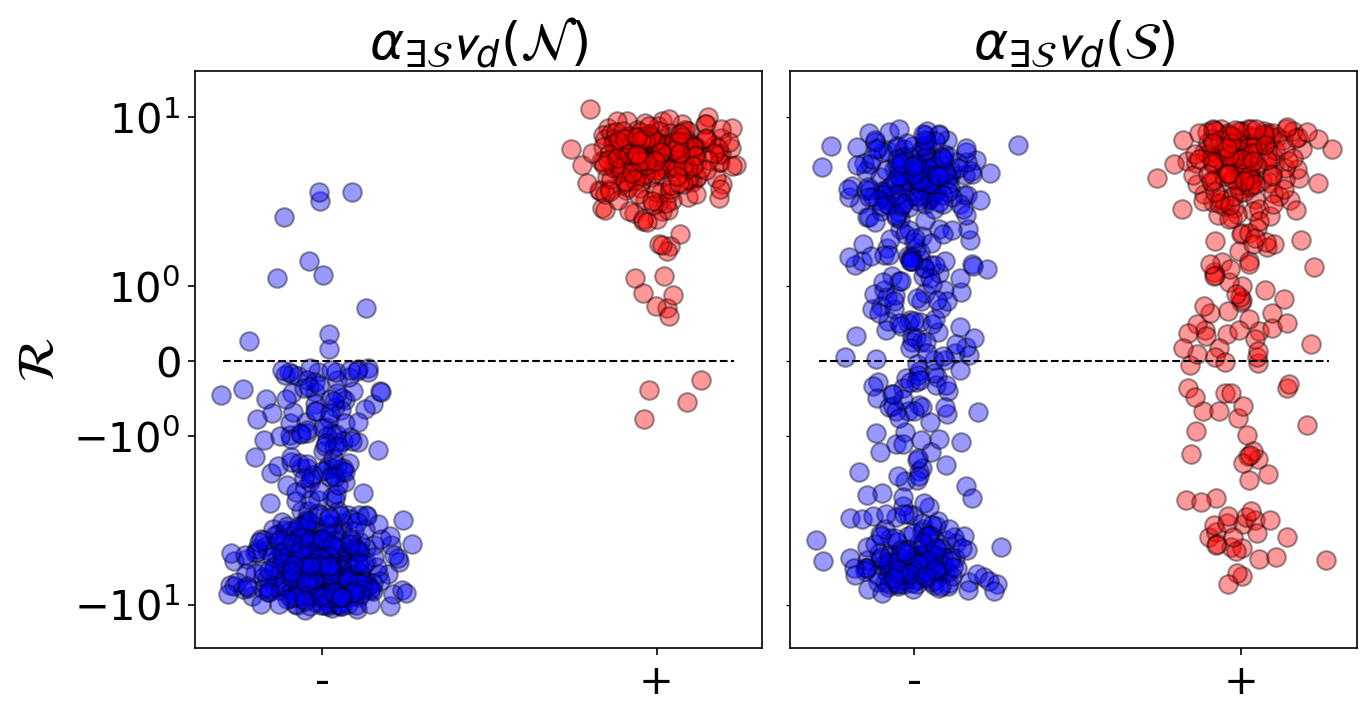

In [10]:
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
axs[0].scatter(xs_pos_or, ys_pos_or, alpha=.4, edgecolors='black', color='red', s=80)
axs[0].scatter(xs_neg_or, ys_neg_or, alpha=.4, edgecolors='black', color='blue', s=80)
# axs[0].set_title("$\mathcal{R}(\\mathcal{S}^\\vee | \, \\mathcal{N})$", size=25)
axs[0].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}_d(\\mathcal{N})$', size=25)
# axs[0].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}(\\mathcal{N})$', size=25)
axs[0].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
axs[0].set_ylabel("$\\mathcal{R}$", size=25)
axs[0].set_xticks([1, 2], ['-', '+'], size=20)
axs[0].set_yscale('symlog')

axs[1].scatter(xs_pos_sub, ys_pos_sub, alpha=.4, edgecolors='black', color='red', s=80)
axs[1].scatter(xs_neg_sub, ys_neg_sub, alpha=.4, edgecolors='black', color='blue', s=80)
# axs[1].set_title("$\mathcal{R}(\\mathcal{S}^\\vee | \, \\mathcal{S})$", size=25)
axs[1].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}_d(\\mathcal{S})$', size=25)
# axs[1].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}(\\mathcal{S})$', size=25)
axs[1].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
lim = np.array(list(axs[1].get_ylim())) + np.array(list(axs[0].get_ylim()))
axs[0].set_ylim(lim)
axs[1].set_ylim(lim)
axs[1].set_yscale('symlog')
axs[1].set_xticks([1, 2], ['-', '+'], size=20)
axs[1].set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig("/home/farnoush/symbolicXAI/figures/shap_imdb_dropped.png", transparent=True)
# plt.show()

In [12]:
# i = 186
i = 70
text = dataset['validation']['review'][i]
label = dataset['validation']['label'][i]

print(text)
print('\nLabel: ' + 'Negative' if label == 0 else 'Positive')
evidences = dataset['validation']['evidences'][i]

tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
target = torch.nn.functional.one_hot(
    torch.tensor(label), num_classes=2)
print(label)
# target = torch.tensor([1, -1])
target = torch.tensor([-1, 1])

sample = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    truncation = True
)
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())

these days , people have rather short attention span and hardly anything can satisfy them for the long run .
1970s nostalgia is already wearing off , and now , people are becoming more and more interested in 1980s .
few years in the future , early 1990s are going to be regarded as next golden age of nostalgia .
however , i doubt that people are going to be very nostalgic about the hollywood products of that period .
one of the reason would surely be films like national lampoon 's loaded weapon 1 , that , in many ways , symbolise the biggest problem of contemporary american film industry - lack of originality and ideas . being made as some kind of parody on lethal weapon series , this film pairs two l . a . policemen - jack colt ( emilio estevez ) , burn - out alcoholic cop on the edge , and wes luger ( samuel l . jackson ) , by - the - book policeman , days away from retirement .
two of them , following the murder of luger 's ex- partner , must confront evil general mortars ( william s

In [12]:
model(**sample)['logits'].argmax()

tensor(1)

In [13]:
if False:

    # Create model.
    tiny_transformer = tiny_transformer_with_3_layers(
        pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2"
    )
    pretrained_embeddings = tiny_transformer.bert.embeddings

    # Load pre-trained weights.
    load_pretrained_weights(
        tiny_transformer,
        '/home/farnoush/fairness/best_model_state_dropout_0.881.bin'
    )

    symb_xai_transformer = TransformerSymbXAI(
        model=tiny_transformer,
        embeddings=pretrained_embeddings,
        sample=sample,
        target=target,
        scal_val=1
    )
    
# Create model.
model = bert_base_uncased_model(
    pretrained_model_name_or_path='textattack/bert-base-uncased-imdb'
)
model.eval()
pretrained_embeddings = model.bert.embeddings

symb_xai_transformer = BERTSymbXAI(sample, target, model, pretrained_embeddings)

In [14]:
tokenized_evidences = []
for i, ev in enumerate(evidences):
    x = tokenizer.encode_plus(
            ev,
            add_special_tokens=True,
            return_token_type_ids=True,
            pad_to_max_length=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation = True
    )

    tokenized_evidences.append(tokenizer.convert_ids_to_tokens(x['input_ids'].squeeze())[1:-1])
    print(tokenized_evidences[i])

['nothing', 'more', 'than', 'a', 'series', 'of', 'gag', '##s']
['the', 'lame', '##ness', 'of', 'humour']
['not', 'worth', 'the', 'effort']
['in', 'the', 'lack', 'plot', ',', 'characters', ',', 'and', ',', 'even', 'original', 'lines']
['lacked', 'any', 'original', 'idea']
['lack', 'of', 'original', '##ity', 'and', 'ideas']
['the', 'rest', 'simply', 'does', 'n', "'", 't', 'work']
['di', '##sor', '##gan', '##ised', 'mess']


In [7]:
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm

[-0.06473304  3.88936272]


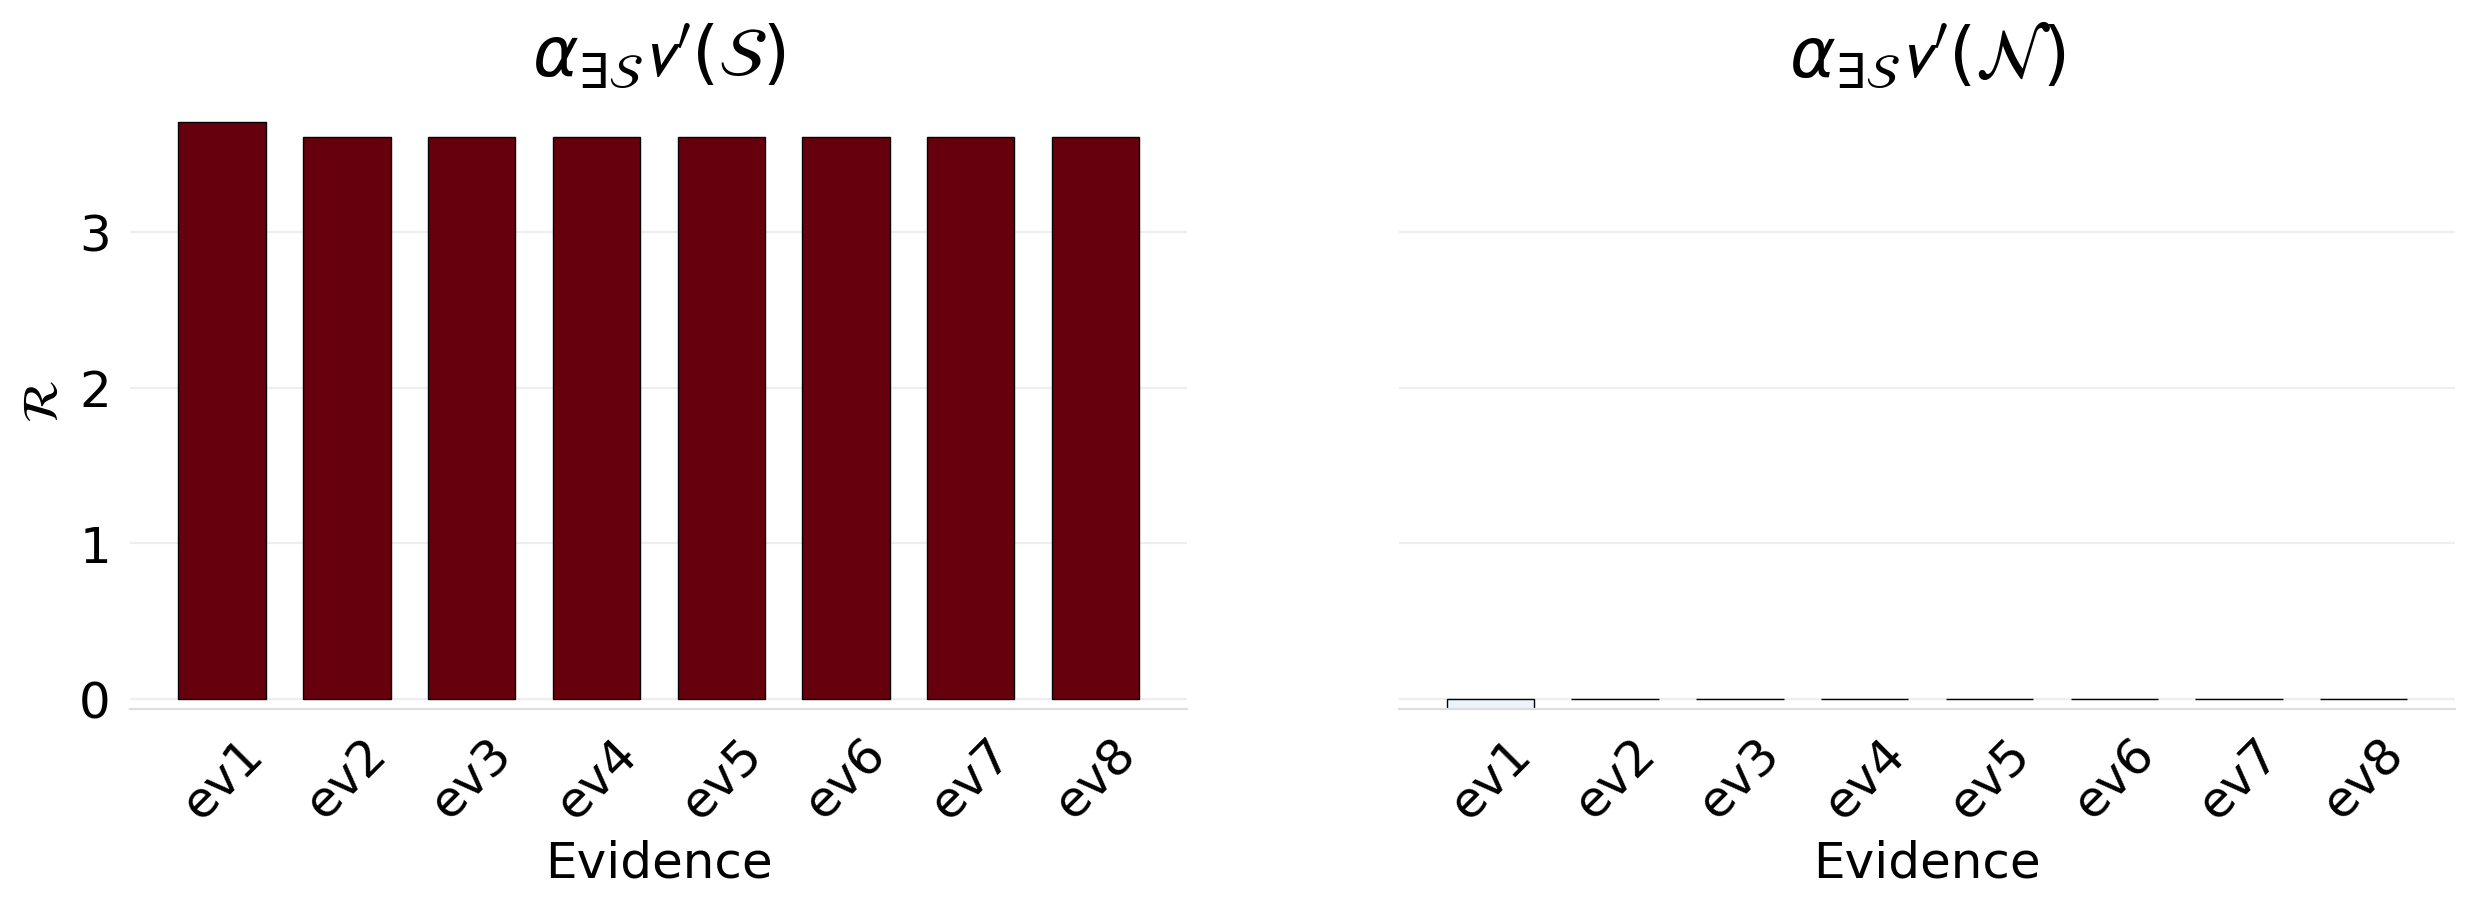

In [18]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'hatch.linewidth': 0.5})
cmap_neg = matplotlib.cm.get_cmap('Blues')
cmap_pos = matplotlib.cm.get_cmap('Reds')

width=0.7
alpha = 1
labels = ['ev{}'.format(i+1) for i in range(len(R_values_sub))]
fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
for i, value in enumerate(R_values_sub):
    if i == 0:
        label = 'Minimal'
    else:
        label = None
        
    if value < 0:
        if label:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5)
    else:
        if label:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_pos(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_pos(abs(value)), width=width, linewidth=0.5)

for i, value in enumerate(R_values_or):
    if i == 0:
        label = 'Full'
    else:
        label = None
        
    if value < 0:
        if label:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5)
    else:
        if label:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_pos(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                      color=cmap_pos(abs(value)), width=width, linewidth=0.5)


for i in range(2):
    ax[i].set_xticks(np.arange(len(R_values_sub)), labels, rotation=45)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')
    ax[i].tick_params(bottom=False, left=False)
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)
    
    if i == 0:
        ax[i].set_ylabel('$\\mathcal{R}$')
    else:
        # pass
        ax[i].set_yticklabels([])
    ax[i].set_xlabel('Evidence')
    ax[i].set_facecolor("white")

# ax.set_title("OR - Minimal vs. Full Context")
# ax[0].set_title("$\mathcal{R}(\\mathcal{S}^\\vee | \, \\mathcal{S})$")
# ax[1].set_title("$\mathcal{R}(\\mathcal{S}^\\vee | \, \\mathcal{N})$")

ax[0].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}^{\prime}(\\mathcal{S})$', size=25)
ax[1].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}^{\prime}(\\mathcal{N})$', size=25)

lim = np.array(list(ax[1].get_ylim())) + np.array(list(ax[0].get_ylim()))
print(lim)
ax[0].set_ylim(lim)
ax[1].set_ylim(lim)


if False:
    legend = ax.legend(title='Context', title_fontsize=18, fontsize=18, loc="upper center",
                       bbox_to_anchor=(.75, .9))
    title = legend.get_title()
    title.set_weight('bold')
    handles = legend.legend_handles

    for i, handle in enumerate(handles):
        handle.set_facecolor("white")

# fig.show()
#plt.tight_layout()
fig.savefig("/home/farnoush/symbolicXAI/figures/imdb_example1_shap.png", facecolor=(1,1,1,0), bbox_inches='tight')

In [5]:
unk_token_id = tokenizer.convert_tokens_to_ids('[UNK]')
cls_token_id = tokenizer.convert_tokens_to_ids('[CLS]')
sep_token_id = tokenizer.convert_tokens_to_ids('[SEP]')

print(cls_token_id)
print(sep_token_id)

# Create a tensor with the [UNK] token ID
unk_token_tensor = torch.tensor([unk_token_id]).unsqueeze(0)
print(unk_token_tensor.shape)

# Pass the tensor through the BERT model's embedding layer
unk_embedding = pretrained_embeddings(input_ids=unk_token_tensor)

101
102
torch.Size([1, 1])


In [16]:
R = np.zeros(len(words))
R_values_sub = []
for ev in tokenized_evidences:
    start, end = find_sub_list(ev, words)[0]
    print(ev)

    if False:
        R_ev = symb_xai_transformer.subgraph_relevance(subgraph=range(start, end+1), from_walks=False)
        R_values_sub.append(R_ev.numpy())
        R[start: end+1] = R_ev.numpy()

    if True:
        subgraph = list(range(start, end+1))
        if 0 not in subgraph:
            subgraph.append(0)
        R_ev = symb_xai_transformer.subgraph_shap_masked(subgraph=subgraph, unk_embedding=unk_embedding)
        R_values_sub.append(R_ev.detach().numpy())
        R[start: end+1] = R_ev.detach().numpy()
    
print('________________________________________________________________________________ \n')
display(HTML(create_text_heat_map(words, R.squeeze(), break_at=21, font_size=15)))

['nothing', 'more', 'than', 'a', 'series', 'of', 'gag', '##s']
['the', 'lame', '##ness', 'of', 'humour']
['not', 'worth', 'the', 'effort']
['in', 'the', 'lack', 'plot', ',', 'characters', ',', 'and', ',', 'even', 'original', 'lines']
['lacked', 'any', 'original', 'idea']
['lack', 'of', 'original', '##ity', 'and', 'ideas']
['the', 'rest', 'simply', 'does', 'n', "'", 't', 'work']
['di', '##sor', '##gan', '##ised', 'mess']
________________________________________________________________________________ 



In [17]:
R = np.zeros(len(words))
R_values_or = []
for ev in tokenized_evidences:
    start, end = find_sub_list(ev, words)[0]

    if True:
        subgraph = list(range(start, end+1))
        if 0 not in subgraph:
            subgraph.append(0)
        R_ev = symb_xai_transformer.symb_or_shap_masked(subgraph, unk_embedding=unk_embedding)
        print(R_ev)
        R_values_or.append(R_ev.detach().numpy())
        R[start: end+1] = R_ev.detach().numpy()

    if False:
        R_ev = symb_xai_transformer.symb_or(range(start, end+1))
        R_values_or.append(R_ev.numpy())
        R[start: end+1] = R_ev
    
print('________________________________________________________________________________ \n')
display(HTML(create_text_heat_map(words, R.squeeze(), break_at=21, font_size=15)))

tensor([-0.0617], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<SubBackward0>)
________________________________________________________________________________ 



## VISUALIZATION

In [4]:
def create_text_heat_map_2(text, heat, font_size=20, break_at=12):
    assert len(text) == len(heat), 'Sorry, the text and heat values needs to have same length.'

    output = '<p style="text-align: justify; text-justify: inter-word;"">'
    for i in range(len(text)):
        if heat[i] == 0:
            opacity = 0.3
        else:
            opacity = 1
        output += '<text style="background-color:rgba(124, 252, 0,{}); font-size:{}px; font-family: serif; opacity: {}">{}</text>'.format(
            heat[i],
            font_size,
            opacity,
            text[i] + ' '
        )

        if i % break_at == 0 and i != 0:
            pass
            # output+='<br>'

    output += '</p>'

    return output

In [77]:
for ev in evidences:
    print(ev)

nothing more than a series of gags
the lameness of humour
not worth the effort
in the lack plot , characters , and , even original lines
lacked any original idea
lack of originality and ideas
the rest simply does n't work
disorganised mess


In [5]:
R = np.zeros(len(words))
for ev in evidences:
    start, end = ev.start_token, ev.end_token
    R[start: end] = 1
    
print('________________________________________________________________________________ \n')
display(HTML(create_text_heat_map_2(words, R.squeeze(), break_at=25, font_size=18)))

________________________________________________________________________________ 



## BEST SUBGARPH

In [ ]:
best_subgraphs = {}

for ev in tokenized_evidences:
    length = len(ev)
    
    sub_scores = {}
    for start in tqdm(range(len(words) - length)):
        end = start + length
        sub_scores[np.abs(symb_xai_transformer.symb_or(range(start, end)))] = range(start, end)
    max_score = max(list(sub_scores.keys()))
    best_subgraphs[sub_scores[max_score]] = max_score       

 47%|███████████████████▏                     | 225/481 [02:48<03:11,  1.34it/s]

In [42]:
best_subgraphs

{range(191, 199): tensor(0.7482),
 range(189, 194): tensor(0.7396),
 range(190, 194): tensor(0.7394),
 range(187, 199): tensor(0.7492),
 range(193, 199): tensor(0.7467)}

In [43]:
R = np.zeros(len(words))
for sub, score in best_subgraphs.items():
    R[sub] = score
    
print('________________________________________________________________________________ \n')
display(HTML(create_text_heat_map(words, R.squeeze(), break_at=21, font_size=15)))

________________________________________________________________________________ 

